In [1]:
# %pip install transformers
# %pip install torch

Charger et utiliser BERT pour la classification de texte.
Générer des représentations vectorielles des phrases avec BERT.
Visualiser les représentations des phrases avec PCA.

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Charger le modèle BERT pré-entraîné pour la classification de texte
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Num_labels = 2 pour la classification binaire


2024-12-03 16:27:56.744422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733239676.765304  193184 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733239676.771636  193184 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 16:27:56.792799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Phrases d'exemple
sentences = [
    "I love this product! It's amazing.",
    "This is the worst experience I've ever had."
]

# Tokeniser les phrases
inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Vérifier les données tokenisées
print("Tokenized Input IDs:", inputs['input_ids'])
print("Attention Mask:", inputs['attention_mask'])


Tokenized Input IDs: tensor([[ 101, 1045, 2293, 2023, 4031,  999, 2009, 1005, 1055, 6429, 1012,  102,
            0],
        [ 101, 2023, 2003, 1996, 5409, 3325, 1045, 1005, 2310, 2412, 2018, 1012,
          102]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [4]:
# Passer les phrases à travers le modèle
with torch.no_grad():
    outputs = model(**inputs)

# Les logits de sortie sont les valeurs avant l'application de la softmax
logits = outputs.logits
print("Logits:", logits)

# Appliquer softmax pour obtenir des probabilités
probs = torch.nn.functional.softmax(logits, dim=-1)
print("Probabilities:", probs)

# Prédire la classe (0 = négatif, 1 = positif)
predictions = torch.argmax(probs, dim=-1)
print("Predictions:", predictions)


Logits: tensor([[-0.3438, -0.0151],
        [-0.4182,  0.0854]])
Probabilities: tensor([[0.4185, 0.5815],
        [0.3767, 0.6233]])
Predictions: tensor([1, 1])


In [5]:
# Charger le modèle BERT de base pour obtenir des embeddings (sans la couche de classification)
from transformers import BertModel

# Charger le modèle BERT
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Passer une phrase à travers le modèle pour obtenir les embeddings
sentence = "BERT is amazing for NLP tasks."
inputs = tokenizer(sentence, return_tensors='pt')

# Obtenir les embeddings sans la tête de classification
with torch.no_grad():
    outputs = model_bert(**inputs)

# `last_hidden_state` est la sortie de chaque token après la dernière couche Transformer
last_hidden_state = outputs.last_hidden_state
print("Last Hidden State Shape:", last_hidden_state.shape)


Last Hidden State Shape: torch.Size([1, 10, 768])


In [6]:
# Représentation de la phrase avec le token [CLS]
sentence_embedding = last_hidden_state[:, 0, :]
print("Sentence Embedding Shape:", sentence_embedding.shape)


Sentence Embedding Shape: torch.Size([1, 768])


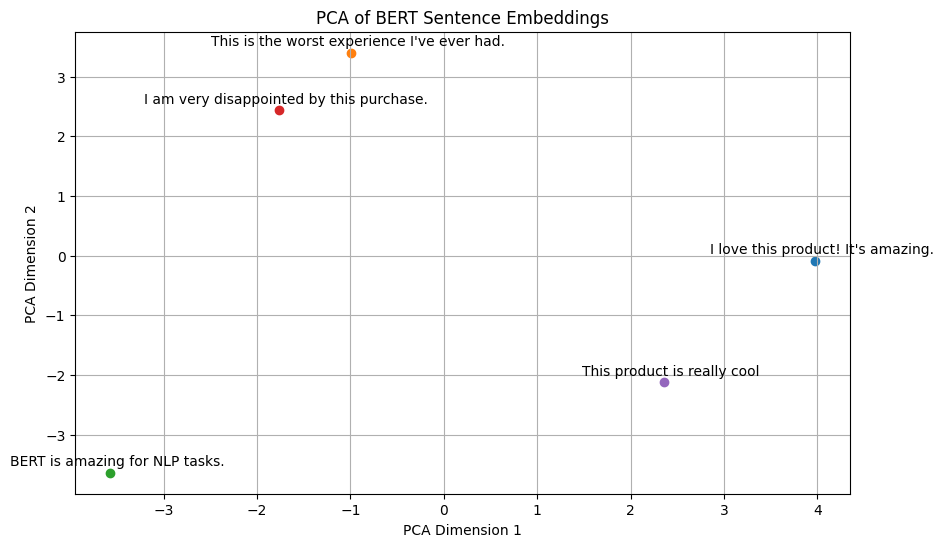

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Obtenir les embeddings de plusieurs phrases
sentences = [
    "I love this product! It's amazing.",
    "This is the worst experience I've ever had.",
    "BERT is amazing for NLP tasks.",
    "I am very disappointed by this purchase.",
    "This product is really cool"
]

# Tokeniser les phrases et obtenir les embeddings
inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=128)
with torch.no_grad():
    outputs = model_bert(**inputs)

# Prendre les représentations [CLS] de chaque phrase
sentence_embeddings = outputs.last_hidden_state[:, 0, :]

# Appliquer PCA pour réduire les dimensions à 2
pca = PCA(n_components=2)
sentence_embeddings_2d = pca.fit_transform(sentence_embeddings)

# Visualiser
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(sentence_embeddings_2d):
    plt.scatter(x, y)
    plt.annotate(sentences[i], (x, y), textcoords="offset points", xytext=(5, 5), ha='center')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('PCA of BERT Sentence Embeddings')
plt.grid(True)
plt.show()
